In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print([np.__version__, pd.__version__])
np.set_printoptions(precision=3, suppress=True)


from src.data_preprocessing import preprocess_data
from src.plotting import plot_heatmap
from src.causal_matrix_evaluation import evaluate_causal_matrices
from src.run_causal_discovery import run_varlingam, run_pcmci, run_varlingam_bootstrap
from src.robust_varlingam import run_rcv_varlingam
from src.robust_pcmci import run_rcv_pcmci

['1.24.4', '2.0.3']


In [2]:
def ground_truth_to_matrices(csv_path):
    # Read the CSV file
    with open(csv_path, 'r') as f:
        content = f.read()

    # Split the content by double newlines to separate matrices
    matrix_strings = content.strip().split('\n\n')
    
    # Convert each matrix string to a numpy array
    matrices = []
    for matrix_string in matrix_strings:
        matrix = np.array([list(map(float, row.split(','))) for row in matrix_string.split('\n')])
        matrices.append(matrix)
    
    return matrices

# Function to load ground truth
def load_ground_truth(data_type):
    ground_truth_path = f'data/synthetic/{data_type}/ground_truth.csv'
    try:
        return ground_truth_to_matrices(ground_truth_path)
    except FileNotFoundError:
        print(f"Ground truth file not found: {ground_truth_path}")
        return None

def save_adjacency_matrices(B_matrices, filepath):
    with open(filepath, 'w') as f:
        for i, B in enumerate(B_matrices):
            np.savetxt(f, B, delimiter=',', fmt='%.3f')
            if i < len(B_matrices) - 1:
                f.write('\n')

In [7]:
def run_experiment(data_type, n_datasets=10):
    methods = ['varlingam', 'pcmci', 'varlingam_bootstrap', 'rcv_varlingam', 'rcv_pcmci']
    # methods = ['varlingam', 'rcv_varlingam']
    # Load ground truth for this data type
    ground_truth_matrices = load_ground_truth(data_type)
    if ground_truth_matrices is None:
        print(f"Skipping experiments for {data_type} due to missing ground truth")
        return
    
    for method in methods:
        results = []
        
        for i in range(n_datasets):
            # Load data
            data = pd.read_csv(f'data/synthetic/{data_type}/dataset_{i}.csv')
            columns = data.columns.tolist()
            if "Date" in columns:
                data = data.drop(['Date'], axis=1).values
                columns.remove('Date')
            else:
                data = data.values
            
            # Preprocess data
            data = preprocess_data(data, columns)
            
            # Run causal discovery method
            start_time = time.time()
            
            if method == 'varlingam':
                result = run_varlingam(data)
                adjacency_matrices = result.adjacency_matrices_
            elif method == 'pcmci':
                adjacency_matrices = run_pcmci(data, columns)
            elif method == 'varlingam_bootstrap':
                adjacency_matrices = run_varlingam_bootstrap(data)
            elif method == 'rcv_varlingam':
                adjacency_matrices = run_rcv_varlingam(data)
            elif method == 'rcv_pcmci':
                adjacency_matrices = run_rcv_pcmci(data)
            
            end_time = time.time()
            runtime = round(end_time - start_time, 4)
            
            # Plot and store the estimated adjacency matrices of the first dataset
            if i == 0:
                if len(adjacency_matrices) > len(ground_truth_matrices):
                    adjacency_matrices_save = adjacency_matrices[:len(ground_truth_matrices)]
                else:
                    adjacency_matrices_save = adjacency_matrices
                plot_heatmap(adjacency_matrices_save, columns, title=f"Heatmap of Adjacency Matrices from {method}")
                output_file = f'results/synthetic/{data_type}/adj_matrices_{method}.csv'
                save_adjacency_matrices(adjacency_matrices_save, output_file)
            # Evaluate results
            evaluation = evaluate_causal_matrices(ground_truth_matrices, adjacency_matrices)
            
            # Store results
            results.append({
                'dataset': f'dataset_{i}',
                'Frobenius': evaluation['fro'],
                'SHD': evaluation['shd'],
                'F1': evaluation['f1'],
                'F1_directed': evaluation['f1_directed'],
                'runtime': runtime
            })
        
        # Calculate average and standard deviation
        avg_result = {
            'dataset': 'Overall Average',
            'Frobenius': f"{np.mean([r['Frobenius'] for r in results]):.3f} ± {np.std([r['Frobenius'] for r in results], ddof=1):.3f}",
            'SHD': f"{np.mean([r['SHD'] for r in results]):.2f} ± {np.std([r['SHD'] for r in results], ddof=1):.2f}",
            'F1': f"{np.mean([r['F1'] for r in results]):.3f} ± {np.std([r['F1'] for r in results], ddof=1):.3f}",
            'F1_directed': f"{np.mean([r['F1_directed'] for r in results]):.3f} ± {np.std([r['F1_directed'] for r in results], ddof=1):.3f}",
            'runtime': f"{np.mean([r['runtime'] for r in results]):.4f} ± {np.std([r['runtime'] for r in results], ddof=1):.4f}"
        }
        results.append(avg_result)
        
        # Save results to CSV
        df_results = pd.DataFrame(results)
        df_results.to_csv(f'results/synthetic/{data_type}/performance_{method}.csv', index=False)

Running experiments for scale_5_var data...


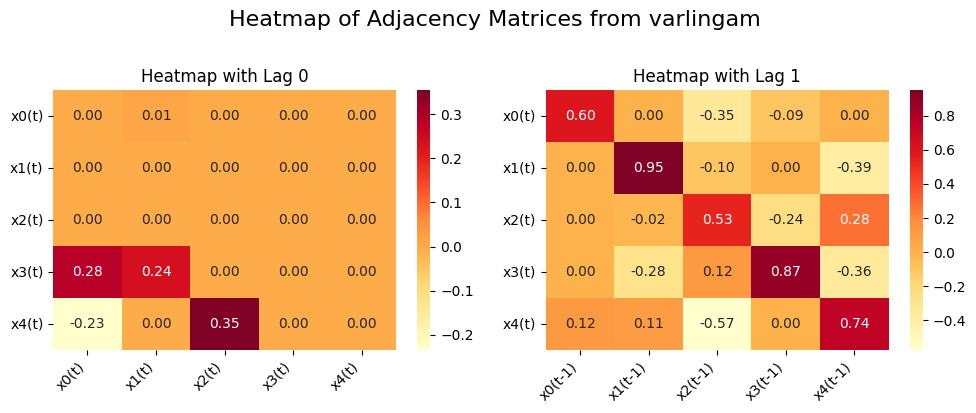

True combined: 
 [[ 0.     0.     0.     0.     0.     0.434  0.    -0.423  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.099  0.696  0.     0.    -0.467]
 [ 0.     0.215  0.     0.     0.     0.004  0.     0.325 -0.231  0.427]
 [ 0.46   0.159  0.099  0.     0.     0.    -0.314  0.331  0.64  -0.487]
 [-0.262  0.     0.366  0.029  0.     0.068  0.    -0.489  0.     0.655]]
Est combined: 
 [[ 0.     0.011  0.     0.     0.     0.604  0.    -0.346 -0.092  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.95  -0.097  0.    -0.388]
 [ 0.     0.     0.     0.     0.     0.    -0.024  0.534 -0.245  0.277]
 [ 0.285  0.236  0.     0.     0.     0.    -0.283  0.125  0.874 -0.359]
 [-0.235  0.     0.355  0.     0.     0.124  0.114 -0.574  0.     0.741]]
True combined: 
 [[ 0.     0.     0.     0.     0.     0.434  0.    -0.423  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.099  0.696  0.     0.    -0.467]
 [ 0.     0.215  0.     0.     0.     0.004  0.     0.325 -0.231  0.427]

<Figure size 640x480 with 0 Axes>

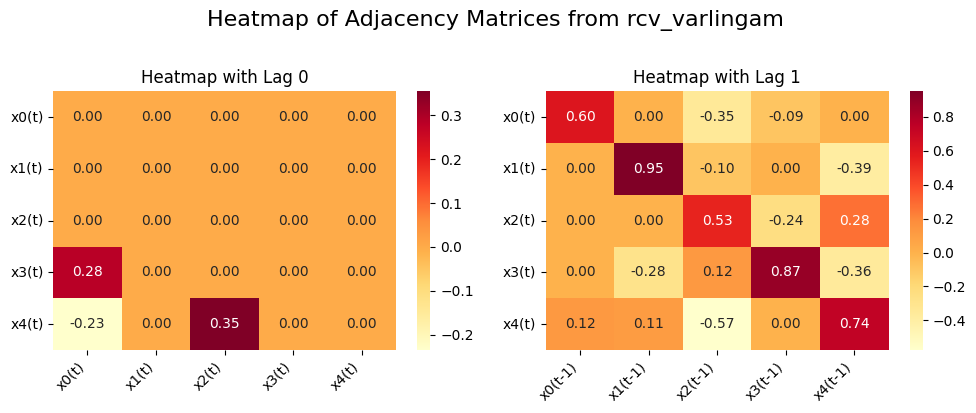

True combined: 
 [[ 0.     0.     0.     0.     0.     0.434  0.    -0.423  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.099  0.696  0.     0.    -0.467]
 [ 0.     0.215  0.     0.     0.     0.004  0.     0.325 -0.231  0.427]
 [ 0.46   0.159  0.099  0.     0.     0.    -0.314  0.331  0.64  -0.487]
 [-0.262  0.     0.366  0.029  0.     0.068  0.    -0.489  0.     0.655]]
Est combined: 
 [[ 0.     0.     0.     0.     0.     0.604  0.    -0.346 -0.092  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.95  -0.097  0.    -0.388]
 [ 0.     0.     0.     0.     0.     0.     0.     0.534 -0.245  0.277]
 [ 0.285  0.     0.     0.     0.     0.    -0.283  0.125  0.874 -0.359]
 [-0.235  0.     0.355  0.     0.     0.124  0.114 -0.574  0.     0.741]]
True combined: 
 [[ 0.     0.     0.     0.     0.     0.434  0.    -0.423  0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.099  0.696  0.     0.    -0.467]
 [ 0.     0.215  0.     0.     0.     0.004  0.     0.325 -0.231  0.427]

<Figure size 640x480 with 0 Axes>

In [8]:
# Run experiments for different data types
data_types = ['scale_5_var', 'scale_15_var', 'linear', 'non_linear', 'gaussian', 'non_gaussian', 'stationary', 'non_stationary', 'sparse', 'dense']
# data_types = ['scale_5_var']
for data_type in data_types:
    print(f"Running experiments for {data_type} data...")
    run_experiment(data_type, n_datasets=10)

print("All experiments completed.")